In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [0]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


fashion_mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.2860,), (0.3530,)),
           ])

def make_mnist(l, batch_size=50, valid=0, shuffle=True, transform=fashion_mnist_transform, path="./"):
    test_data = l(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = l(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader

def fashion_mnist(batch_size=50, valid=0, shuffle=True, transform=fashion_mnist_transform, path='./FashionMNIST_data'):
    return make_mnist(datasets.FashionMNIST, batch_size, valid, shuffle, transform, path)

def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()
    
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()
        

In [0]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np

In [0]:
train_loader, valid_loader, test_loader = fashion_mnist(valid=10000)

In [0]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, xa=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128*3)
        self.fc2 = nn.Linear(128*3, 200)
        self.fc3 = nn.Linear(200, 10)
        if xa:
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128*3)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.tanh(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [0]:
def train(epoch, models):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [0]:
device = torch.device("cuda")

In [0]:
#models = {'xa': Net(False, False, xa=True, l2=1e-5)}
models = {'xa': Net(False, False, xa=True, l2=1e-5), 'xa_bn': Net(True, False, xa=True, l2=1e-5)}
#models = {'default': Net(False, False), 'xa': Net(False, False, xa=True)}
#models = {'default': Net(False, False), 'bn': Net(True, False), 'drop': Net(False, True), 'both': Net(True, True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [0]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [21]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train Epoch: 1 [0/50000 (0%)]	Losses xa: 2.721074 xa_bn: 2.431519
Train Epoch: 1 [10000/50000 (20%)]	Losses xa: 0.490287 xa_bn: 0.525995
Train Epoch: 1 [20000/50000 (40%)]	Losses xa: 0.582648 xa_bn: 0.605012
Train Epoch: 1 [30000/50000 (60%)]	Losses xa: 0.446291 xa_bn: 0.565038
Train Epoch: 1 [40000/50000 (80%)]	Losses xa: 0.455784 xa_bn: 0.421289
Train Epoch: 1 [50000/50000 (100%)]	Losses xa: 0.483971 xa_bn: 0.514177
Test set:
xa: Loss: 0.4061	Accuracy: 8507/10000 (85%)
xa_bn: Loss: 0.3944	Accuracy: 8570/10000 (85%)

Train Epoch: 2 [0/50000 (0%)]	Losses xa: 0.145341 xa_bn: 0.179419
Train Epoch: 2 [10000/50000 (20%)]	Losses xa: 0.461655 xa_bn: 0.502909
Train Epoch: 2 [20000/50000 (40%)]	Losses xa: 0.335151 xa_bn: 0.330273
Train Epoch: 2 [30000/50000 (60%)]	Losses xa: 0.409303 xa_bn: 0.391859
Train Epoch: 2 [40000/50000 (80%)]	Losses xa: 0.290760 xa_bn: 0.290688
Train Epoch: 2 [50000/50000 (100%)]	Losses xa: 0.334274 xa_bn: 0.315733
Test set:
xa: Loss: 0.3616	Accuracy: 8694/10000 (86%)


KeyboardInterrupt: ignored

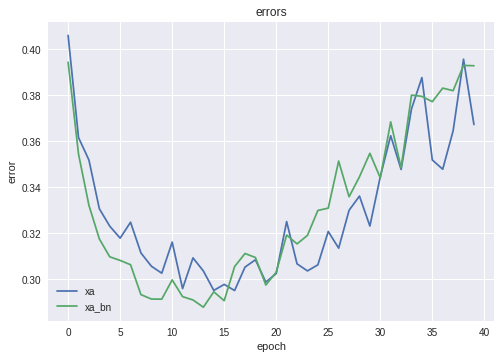

In [22]:
plot_graphs(test_log, 'loss')

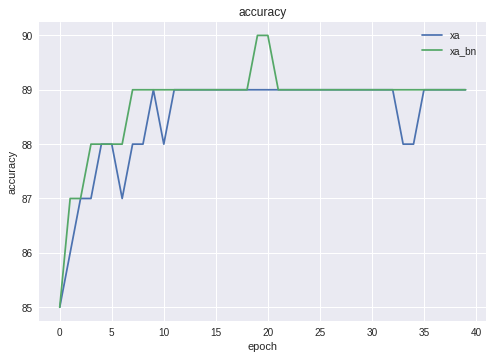

In [23]:
plot_graphs(test_log, 'accuracy')